<a href="https://colab.research.google.com/github/harshsaxena07/SIEM/blob/main/SIEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


FileUpload(value={}, accept='.csv', description='Upload')

Button(description='Upload CSV', style=ButtonStyle())

Button(description='Plot Data', style=ButtonStyle())

Button(description='Detect Anomalies', style=ButtonStyle())

,timestamp,event_id,source_ip,destination_ip,bytes_sent,bytes_received
0,2022-10-22T20:53:11Z,1,105.252.224.98,230.140.227.176,775154,121816
1,2020-05-07T00:33:44Z,2,20.241.145.76,142.223.20.52,741536,549572
2,2022-01-04T16:53:16Z,3,41.36.230.85,219.202.198.29,196899,631659
3,2022-12-07T03:27:55Z,4,154.192.127.44,208.95.69.229,202043,274140
4,2021-10-25T02:11:03Z,5,109.138.203.96,118.126.213.35,23530,636670


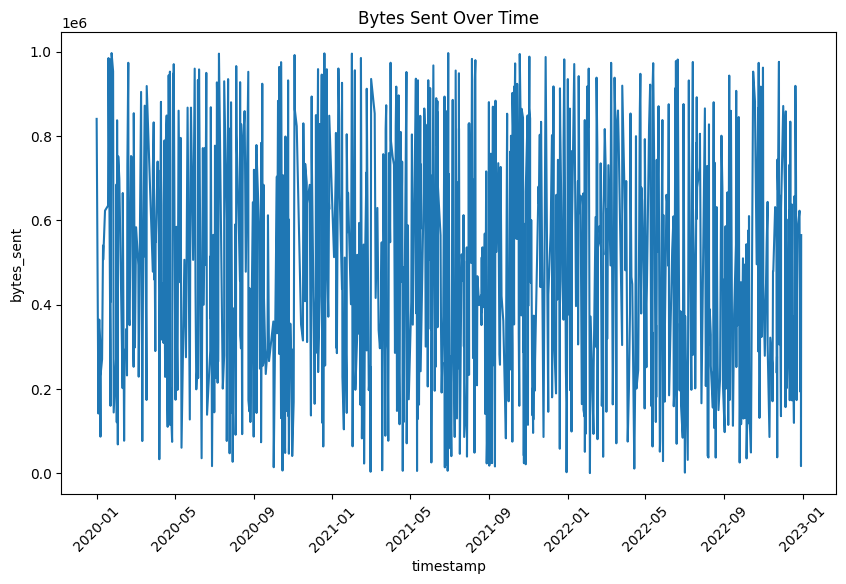

Anomalies detected: 10


,timestamp,event_id,source_ip,destination_ip,bytes_sent,bytes_received,timestamp_numeric,anomaly_score,is_anomaly
125,2020-01-24 07:39:48+00:00,126,236.184.240.181,255.31.59.8,996570,170288,1.579852e+09,-0.014108,-1
152,2020-01-22 15:45:49+00:00,153,190.185.67.129,114.210.74.66,981264,223638,1.579708e+09,-0.000205,-1
227,2020-01-07 01:41:56+00:00,228,188.178.0.187,101.247.24.87,86431,13853,1.578361e+09,-0.041528,-1
412,2022-12-20 06:26:16+00:00,413,228.159.82.116,186.169.244.129,918785,154122,1.671518e+09,-0.002640,-1
574,2020-01-03 21:10:28+00:00,575,196.101.241.192,244.215.149.71,141361,917564,1.578086e+09,-0.001531,-1
680,2022-07-06 06:09:57+00:00,681,166.99.100.22,56.86.61.135,31346,983388,1.657088e+09,-0.002637,-1
762,2022-12-12 08:26:49+00:00,763,254.38.63.176,174.141.90.251,833874,991664,1.670834e+09,-0.007856,-1
763,2022-12-28 22:43:38+00:00,764,124.181.160.158,209.226.204.44,16652,425858,1.672267e+09,-0.003229,-1
796,2020-04-27 06:15:27+00:00,797,165.132.106.158,75.186.62.149,74098,977181,1.587968e+09,-0.002269,-1
803,2020-01-19 12:21:20+00:00,804,186.135.209.29,5.221.159.246,984700,257332,1.579436e+09,-0.005566,-1


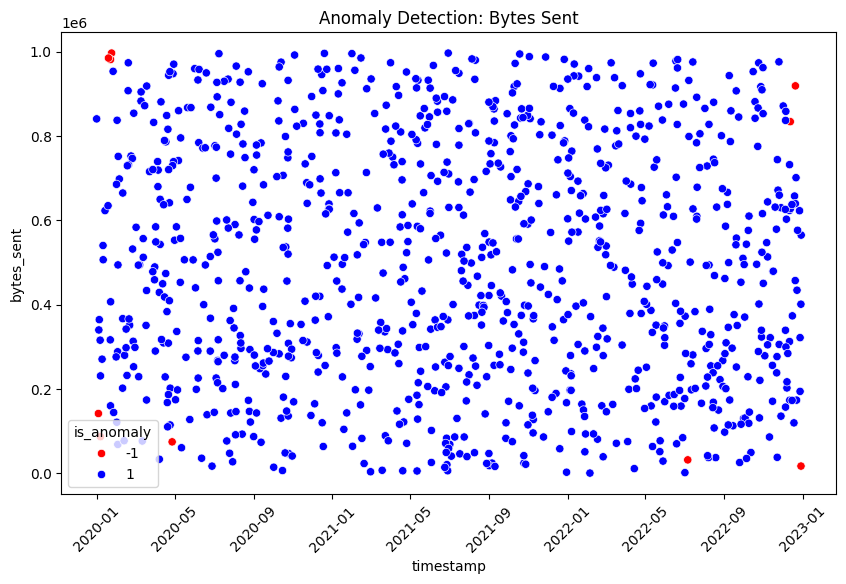

In [ ]:
import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


def load_and_display_data(file):
    try:
        df = pd.read_csv(io.BytesIO(file['content']))
        display(df.head())
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


def plot_data(df):
    if df is not None:
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='timestamp', y='bytes_sent', data=df)
            plt.title('Bytes Sent Over Time')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("Timestamp column is missing")

def detect_anomalies(df):
    if df is not None:
        if 'timestamp' in df.columns and 'bytes_sent' in df.columns and 'bytes_received' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df['timestamp_numeric'] = df['timestamp'].astype(int) / 10**9
            features = ['timestamp_numeric', 'bytes_sent', 'bytes_received']
            data = df[features]

            scaler = StandardScaler()
            data_normalized = scaler.fit_transform(data)

            model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
            model.fit(data_normalized)
            df['anomaly_score'] = model.decision_function(data_normalized)
            df['is_anomaly'] = model.predict(data_normalized)
            anomalies = df[df['is_anomaly'] == -1]
            print(f"Anomalies detected: {len(anomalies)}")
            display(anomalies)
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x='timestamp', y='bytes_sent', data=df, hue='is_anomaly', palette={1: 'blue', -1: 'red'})
            plt.title('Anomaly Detection: Bytes Sent')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("Required columns ('timestamp', 'bytes_sent', 'bytes_received') are missing")
    else:
        print("No data available to detect anomalies")


file_upload = widgets.FileUpload(
    accept='.csv',
    multiple=False
)
upload_button = widgets.Button(description="Upload CSV")
plot_button = widgets.Button(description="Plot Data")
anomaly_button = widgets.Button(description="Detect Anomalies")
df = None


def on_upload_button_clicked(b):
    global df
    if file_upload.value:
        uploaded_file = list(file_upload.value.values())[0]
        df = load_and_display_data(uploaded_file)
    else:
        print("No file uploaded!")

def on_plot_button_clicked(b):
    plot_data(df)
def on_anomaly_button_clicked(b):
    detect_anomalies(df)


upload_button.on_click(on_upload_button_clicked)
plot_button.on_click(on_plot_button_clicked)
anomaly_button.on_click(on_anomaly_button_clicked)


display(file_upload, upload_button, plot_button, anomaly_button)